<a href="https://colab.research.google.com/github/yuvalira/Adversarial-Attacks-Article/blob/main/models/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classical Model — Random Forest (RF)**
Random Forests are an ensemble of decision trees trained on bootstrapped samples with feature subsampling.
They capture **non-linear** relationships, are fairly robust to hyperparameters, and provide **feature importances**.
Unlike linear models, RF does **not** require scaling.

References:
- [scikit-learn RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)


## Imports & setup

In [1]:
!pip -q install -U scikit-learn huggingface_hub

import os, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 95.9 MB/s eta 0:00:00


## Load splits from HF

In [2]:
repo_id   = "yuvalira/adult_income_balanced"  # TODO
repo_type = "dataset"

def read_split_csv(repo_id, filename, repo_type="dataset"):
    p = hf_hub_download(repo_id=repo_id, filename=filename, repo_type=repo_type, token=False)
    return pd.read_csv(p)

train_data = read_split_csv(repo_id, "train.csv", repo_type)
val_data   = read_split_csv(repo_id, "val.csv",   repo_type)

print("Train:", train_data.shape, "| Val:", val_data.shape)

train.csv: 0.00B [00:00, ?B/s]

val.csv: 0.00B [00:00, ?B/s]

Train: (11687, 14) | Val: (2337, 14)


## Discover column types & configure target

In [3]:
auto_num = train_data.select_dtypes(include=['int16','int32','int64','float16','float32','float64']).columns.tolist()
auto_cat = train_data.select_dtypes(include=['object','category','bool']).columns.tolist()

TARGET_COLUMN_NAME = "income"              # TODO
TARGET_LABELS = ["<=50K", ">50K"]          # TODO (order defines ids)
SAMPLE_WEIGHT_COLUMN = None                # or "weight"

NUMERIC_FEATURE_NAMES = [c for c in auto_num if c != TARGET_COLUMN_NAME]
CATEGORICAL_FEATURE_NAMES = [c for c in auto_cat if c != TARGET_COLUMN_NAME]

print("Numeric features:", NUMERIC_FEATURE_NAMES)
print("Categorical features:", CATEGORICAL_FEATURE_NAMES)

Numeric features: ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical features: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']


## Prepare dataframes

In [4]:
train_data = train_data.copy()
val_data   = val_data.copy()

label2id = {lbl:i for i,lbl in enumerate(TARGET_LABELS)}
id2label = {i:lbl for lbl,i in label2id.items()}

def prepare_df(df):
    assert TARGET_COLUMN_NAME in df.columns, f"No target '{TARGET_COLUMN_NAME}'"
    df[TARGET_COLUMN_NAME] = df[TARGET_COLUMN_NAME].map(label2id)
    if df[TARGET_COLUMN_NAME].isna().any():
        bad = df.loc[df[TARGET_COLUMN_NAME].isna(), TARGET_COLUMN_NAME].unique().tolist()
        raise ValueError(f"Unmapped targets: {bad} vs {TARGET_LABELS}")
    for c in CATEGORICAL_FEATURE_NAMES:
        if c in df.columns:
            df[c] = df[c].astype(str)
    return df

prepare_df(train_data); prepare_df(val_data)
n_classes = int(train_data[TARGET_COLUMN_NAME].nunique())
avg_mode = None if n_classes==2 else "macro"
print("Classes:", [id2label[i] for i in sorted(train_data[TARGET_COLUMN_NAME].unique())])

Classes: ['<=50K', '>50K']


## Pipeline: impute numerics; ordinal-encode categoricals (no scaling); RF model

In [5]:
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, NUMERIC_FEATURE_NAMES),
        ("cat", categorical_pipe, CATEGORICAL_FEATURE_NAMES),
    ],
    remainder="drop",
    verbose_feature_names_out=True
)

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,           # let trees grow; adjust if overfitting
    min_samples_leaf=2,
    max_features="sqrt",
    bootstrap=True,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

clf_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", rf),
])

print("RF pipeline ready.")

RF pipeline ready.


## Train & Evaluate

In [6]:
def split_Xy(df):
    X = df.drop(columns=[TARGET_COLUMN_NAME])
    y = df[TARGET_COLUMN_NAME].values
    sw = df[SAMPLE_WEIGHT_COLUMN].values if SAMPLE_WEIGHT_COLUMN else None
    return X, y, sw

def metrics(y_true, y_pred, y_prob=None, average=None, sample_weight=None):
    acc = accuracy_score(y_true, y_pred, sample_weight=sample_weight)
    if average is None:
        prec = precision_score(y_true, y_pred, sample_weight=sample_weight, zero_division=0)
        rec  = recall_score(y_true, y_pred, sample_weight=sample_weight, zero_division=0)
        f1   = f1_score(y_true, y_pred, sample_weight=sample_weight, zero_division=0)
    else:
        prec = precision_score(y_true, y_pred, average=average, sample_weight=sample_weight, zero_division=0)
        rec  = recall_score(y_true, y_pred, average=average, sample_weight=sample_weight, zero_division=0)
        f1   = f1_score(y_true, y_pred, average=average, sample_weight=sample_weight, zero_division=0)
    out = {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1}
    if y_prob is not None:
        try:
            if y_prob.ndim==1 or y_prob.shape[1]==1:
                auc = roc_auc_score(y_true, y_prob, sample_weight=sample_weight)
            elif y_prob.shape[1]==2:
                auc = roc_auc_score(y_true, y_prob[:,1], sample_weight=sample_weight)
            else:
                auc = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro", sample_weight=sample_weight)
            out["roc_auc"] = auc
        except Exception:
            pass
    return out

def run_rf_train_val(pipeline, train_df, val_df):
    Xtr, ytr, sw_tr = split_Xy(train_df)
    Xva, yva, sw_va = split_Xy(val_df)

    t0 = time.time()
    fit_kwargs = {"clf__sample_weight": sw_tr} if sw_tr is not None else {}
    pipeline.fit(Xtr, ytr, **fit_kwargs)
    print(f"Training time: {time.time()-t0:.2f}s")

    y_pred = pipeline.predict(Xva)
    y_prob = pipeline.predict_proba(Xva) if hasattr(pipeline.named_steps["clf"], "predict_proba") else None

    res = metrics(yva, y_pred, y_prob, average=avg_mode, sample_weight=sw_va)
    print("Validation metrics:", {k: round(v,4) for k,v in res.items()})

    print("\nClassification report (val):")
    print(classification_report(yva, y_pred, target_names=[id2label[i] for i in range(n_classes)], zero_division=0))
    print("Confusion matrix (val):")
    print(confusion_matrix(yva, y_pred))
    return pipeline, (Xva, yva, y_prob)

In [7]:
clf_rf, (X_val, y_val, y_prob_val) = run_rf_train_val(clf_rf, train_data, val_data)

Training time: 5.99s
Validation metrics: {'accuracy': 0.8288, 'precision': 0.8057, 'recall': 0.8664, 'f1': 0.835, 'roc_auc': 0.9158}

Classification report (val):
              precision    recall  f1-score   support

       <=50K       0.86      0.79      0.82      1169
        >50K       0.81      0.87      0.83      1168

    accuracy                           0.83      2337
   macro avg       0.83      0.83      0.83      2337
weighted avg       0.83      0.83      0.83      2337

Confusion matrix (val):
[[ 925  244]
 [ 156 1012]]


## ROC Curve

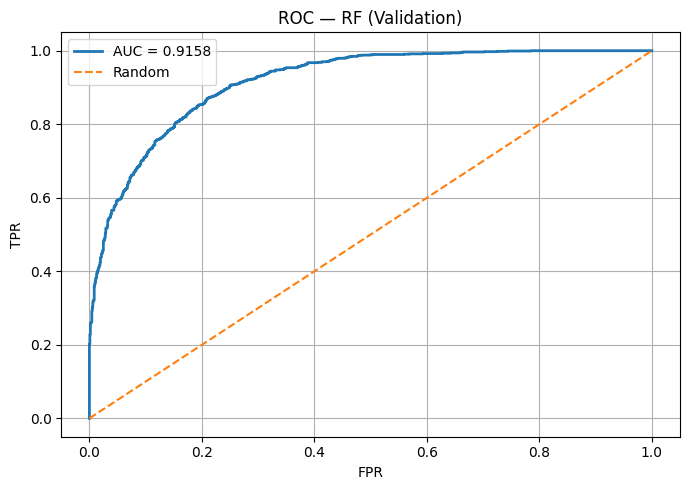

In [8]:
if y_prob_val is not None:
    if n_classes==2:
        scores = y_prob_val[:,1] if y_prob_val.ndim>1 else y_prob_val
        fpr, tpr, _ = roc_curve(y_val, scores)
        auc = roc_auc_score(y_val, scores)
        plt.figure(figsize=(7,5))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", linewidth=2)
        plt.plot([0,1],[0,1],'--', label="Random")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — RF (Validation)")
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
    else:
        print("Multiclass ROC: compute macro/micro as needed.")

## Save Model

In [ ]:
import re, joblib
safe_repo_id = re.sub(r'[^A-Za-z0-9_.-]+', '_', repo_id)
model_path = f"rf_pipeline_{safe_repo_id}.joblib"
joblib.dump(clf_rf, model_path)
print("Saved:", os.path.abspath(model_path))